<h2><b>Bean Disease Classification Model</b></h2>

<h2><b>Importing necessary Libraries and Modules</b></h2>

In [3]:
import keras
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3


In [2]:
# Define data directories
train_dir = "Beans_diseases_datasetT2/train"
test_dir = "Beans_diseases_datasetT2/test"


<h2><b>Data Visualization</b></h2>

Found 792 files belonging to 3 classes.


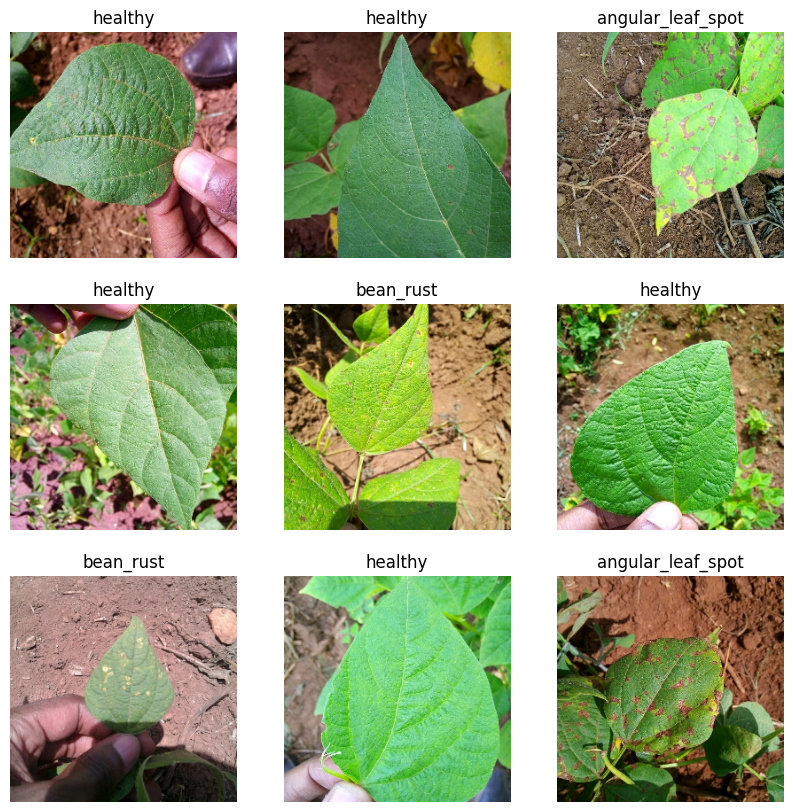

In [3]:
class_names = ["angular_leaf_spot", "bean_rust", "healthy"]
train_ds = tf.keras.utils.image_dataset_from_directory("Beans_diseases_datasetT2/train")
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [2]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32
num_classes = 3


<h2><b>Transfer Learning</b></h2>

In [4]:
# Load MobileNetV2 base model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, num_classes))

2024-06-27 16:46:47.657780: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-06-27 16:46:47.657811: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-27 16:46:47.657819: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-27 16:46:47.658065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-27 16:46:47.658092: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

<h2><b>Create Model</b></h2>

In [7]:
# Create model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

<h2><b>Compile Model</b></h2>

In [8]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/train",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 792 images belonging to 3 classes.


In [11]:
validation_generator = test_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/validation",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 99 images belonging to 3 classes.


<h2><b>Train Model</b></h2>

In [12]:
# Train model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=64,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size)
training_time = time.time() - start_time

Epoch 1/64
24/24 [==============================] - 51s 2s/step - loss: 1.3023 - accuracy: 0.5038 - val_loss: 0.7099 - val_accuracy: 0.7172
Epoch 2/64
24/24 [==============================] - 47s 2s/step - loss: 0.6113 - accuracy: 0.7361 - val_loss: 0.6012 - val_accuracy: 0.7374
Epoch 3/64
24/24 [==============================] - 47s 2s/step - loss: 0.5036 - accuracy: 0.8018 - val_loss: 0.5126 - val_accuracy: 0.8182
Epoch 4/64
24/24 [==============================] - 49s 2s/step - loss: 0.4328 - accuracy: 0.8409 - val_loss: 0.5346 - val_accuracy: 0.8283
Epoch 5/64
24/24 [==============================] - 49s 2s/step - loss: 0.3956 - accuracy: 0.8409 - val_loss: 0.5215 - val_accuracy: 0.7980
Epoch 6/64
24/24 [==============================] - 47s 2s/step - loss: 0.5166 - accuracy: 0.7917 - val_loss: 0.6576 - val_accuracy: 0.7980
Epoch 7/64
24/24 [==============================] - 48s 2s/step - loss: 0.4306 - accuracy: 0.8119 - val_loss: 0.5069 - val_accuracy: 0.8081
Epoch 8/64
24/24 [==

24/24 [==============================] - 46s 2s/step - loss: 0.0834 - accuracy: 0.9697 - val_loss: 0.5364 - val_accuracy: 0.7879
Epoch 60/64
24/24 [==============================] - 46s 2s/step - loss: 0.1130 - accuracy: 0.9583 - val_loss: 0.6126 - val_accuracy: 0.7879
Epoch 61/64
24/24 [==============================] - 47s 2s/step - loss: 0.1040 - accuracy: 0.9634 - val_loss: 0.5319 - val_accuracy: 0.8081
Epoch 62/64
24/24 [==============================] - 46s 2s/step - loss: 0.0918 - accuracy: 0.9697 - val_loss: 0.5106 - val_accuracy: 0.8182
Epoch 63/64
24/24 [==============================] - 47s 2s/step - loss: 0.0965 - accuracy: 0.9634 - val_loss: 0.6597 - val_accuracy: 0.7980
Epoch 64/64
24/24 [==============================] - 47s 2s/step - loss: 0.1178 - accuracy: 0.9571 - val_loss: 0.4948 - val_accuracy: 0.8384


<h2><b>Evaluate Model</b></h2>

In [13]:
# Evaluate model
test_generator = test_datagen.flow_from_directory(
    "Beans_diseases_datasetT2/test",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 99 images belonging to 3 classes.


In [14]:
# Print model Summary
#model.summary()

In [17]:
y_true = test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

4/4 [==============================] - 5s 1s/step


In [18]:
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Recall:", recall)
print("precision:", precision)
print("Traininig Time: ", training_time)

Accuracy: 0.8282828282828283
Recall: 0.8282828282828283
precision: 0.834547152194211
Traininig Time:  3049.5213618278503


In [19]:
# Save the model
#model.save('my_model')

<h2><b>Confusion Matrix</b></h2>

In [20]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[27  5  1]
 [ 7 26  0]
 [ 0  4 29]]


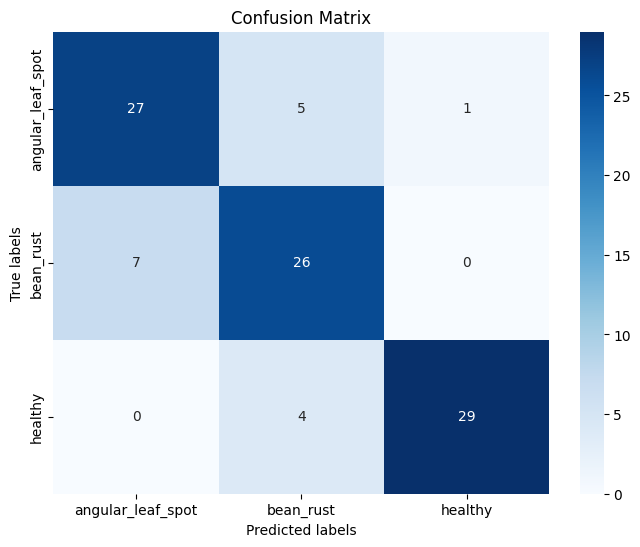

In [21]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices, yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

<h2><b>Classification Report</b></h2>

In [22]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.79      0.82      0.81        33
        bean_rust       0.74      0.79      0.76        33
          healthy       0.97      0.88      0.92        33

         accuracy                           0.83        99
        macro avg       0.83      0.83      0.83        99
     weighted avg       0.83      0.83      0.83        99



<h2><b>Accuracy Graph</b></h2>

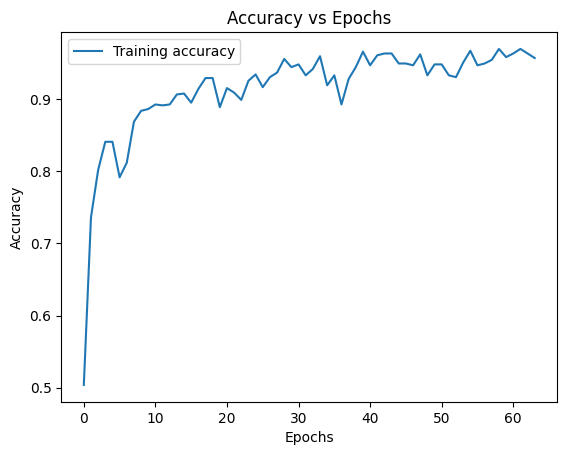

In [23]:
# Plotting accuracy vs epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

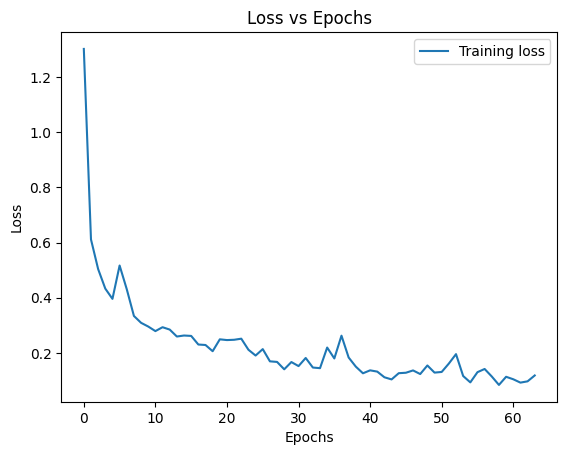

In [24]:
# Plotting loss vs epochs
plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

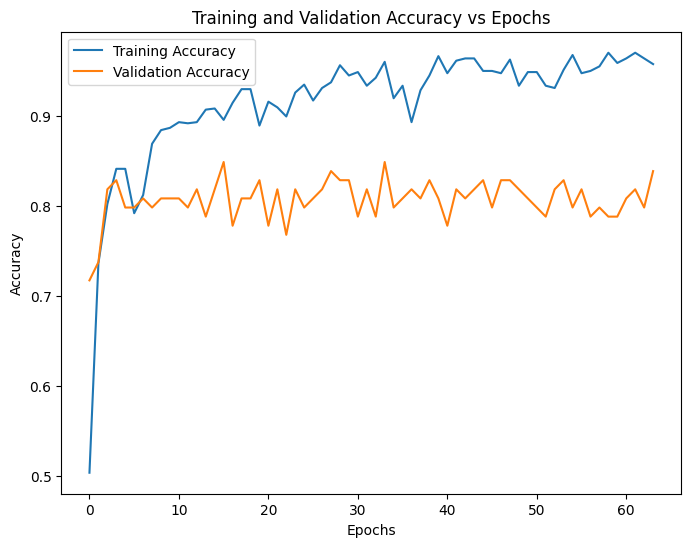

In [25]:
# Plot testing accuracy vs epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

<h2><b>Save current Model and Loading another model for prediction</b></h2>

<h2><b>Testing Model Performance</b></h2>

In [ ]:
import numpy
# Load the entire model
loaded_model = tf.keras.models.load_model('my_model')
#test_ds = tf.keras.utils.image_dataset_from_directory("Beans_diseases_dataset/test")
test_ds = tf.keras.utils.image_dataset_from_directory(
    "Beans_diseases_datasetT/test",
    image_size = (img_width, img_height),
    batch_size = batch_size
)
plt.figure(figsize=(20,20))
for images, labels in test_ds.take(1):
  classifications = loaded_model(images)
  #classifications = loaded_model(images)
  # print(classifications)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    class_names = test_ds.class_names
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]]) 

<h2><b>Converting our Model to Tensorflow_Lite Model for Android APP</b></h2>

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

<h2><b>Done!</b></h2>